# **Transformed Homogeneous 2D wave equation**:
# $ g_{xx} + g_{yy} + 16\pi^2g = 16\pi^2\cos\left[ 4\pi(x-y) \right] \qquad 0 < x < 1, \quad 0<y<1, \quad g ≡ g(x,y)$

## Boundary conditions (Dirichlet):
* $ g(x, 0) = \cos(4\pi x) \qquad 0 \leq x \leq 1$
* $ g(x, 1) = \cos(4\pi x) \qquad 0 \leq x \leq 1$
* $ g(0, y) = \cos(4\pi y) \qquad 0 \leq y \leq 1$
* $ g(1, y) = \cos(4\pi y) \qquad 0 \leq y \leq 1$

## *ANALYTICAL SOLUTION*
## $ g(x, y) = \cos\left[ 4\pi(x-y) \right] $

## *ORIGINAL SOLUTION*
## $ u(x, y) = g(x, y) - \cos(4\pi x)\cos(4\pi y) = \sin(4\pi x)\sin(4\pi y) $



# Imports

In [9]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Helpers

In [16]:
def generate_random_numbers(N, dtype):
    random_numbers = torch.rand(N - 1, dtype=dtype)
    random_numbers = torch.cat([random_numbers, torch.tensor([1.0], dtype=dtype)])
    return random_numbers

## Data

In [17]:
class Data():
  def __init__(self, device='cpu', dtype=torch.float32):
    super().__init__()
    self.device = device
    self.dtype = dtype

  # *** Create collocation points ***
  def sample_domain(self, Nx_domain, Ny_domain, is_test=False):
    # Random Grid
    x_domain = generate_random_numbers(Nx_domain, self.dtype)
    y_domain = generate_random_numbers(Ny_domain, self.dtype)
    XY_domain = torch.stack(torch.meshgrid(x_domain, y_domain)).reshape(2, -1).T.requires_grad_(True).to(self.device)
    print(XY_domain.shape)

    if is_test:
        return x_domain, y_domain, XY_domain

    return XY_domain

  # *** Boundary Conditions ***
  # 1. g(x,0) = cos(4πx)
  # 2. g(x,1) = cos(4πx)
  # 3. g(0,y) = cos(4πy)
  # 4. g(1,y) = cos(4πy)
  def sample_boundary(self, Nx_b, Ny_b):
    # Random boundary points
    self.h_x_b = 1e-4
    self.h_y_b = 1e-4
    x_b = torch.arange(0, 1+self.h_x_b, self.h_x_b)
    y_b = torch.arange(0, 1+self.h_y_b, self.h_y_b)
    # x_b = generate_random_numbers(Nx_b, self.dtype)
    # y_b = generate_random_numbers(Ny_b, self.dtype)

    bc1 = torch.stack(torch.meshgrid(x_b[0], y_b)).reshape(2,-1).T
    bc2 = torch.stack(torch.meshgrid(x_b[-1], y_b)).reshape(2,-1).T
    bc3 = torch.stack(torch.meshgrid(x_b, y_b[0])).reshape(2,-1).T
    bc4 = torch.stack(torch.meshgrid(x_b, y_b[-1])).reshape(2,-1).T

    XY_b = torch.cat([bc1, bc2, bc3, bc4]).to(self.device)
    print(f"shape(X_b) = {XY_b.shape}")

    gb_x = torch.cos(4*math.pi*x_b)
    gb_y = torch.cos(4*math.pi*y_b)
    g_b = torch.cat([gb_y, gb_y, gb_x, gb_x]).unsqueeze(1).to(self.device)
    print(f"shape(g_b) = {g_b.shape}")

    return XY_b, g_b

## Network

In [18]:
class MLP(nn.Module):
  def __init__(self,
               layers,
               activation=nn.Tanh(),
               weight_init=None,
               bias_init=None,
               device='cpu'):

    super().__init__()
    self.n_layers = len(layers) - 1
    self.layers = layers
    self.activation = activation
    self.weight_init = weight_init
    self.bias_init = bias_init

    dense_layers = [
        self.dense_layer(in_features=self.layers[i],
                         out_features=self.layers[i+1])
        for i in range(self.n_layers - 1)]
    dense_layers.append(nn.Linear(in_features=self.layers[-2],
                                  out_features=self.layers[-1]))

    self.mlp = nn.Sequential(*dense_layers).to(device)

  def dense_layer(self, in_features, out_features):
    dense_layer = nn.Sequential(
      nn.Linear(in_features=in_features,
                out_features=out_features),
    )

    if self.weight_init is not None:
        self.weight_init(dense_layer[0].weight)

    if self.bias_init is not None:
        self.bias_init(dense_layer[0].bias)

    dense_layer.add_module("activation", self.activation)
    return dense_layer

  def forward(self, x):
    return self.mlp(x)

## ReLoBRaLo

In [19]:
class ReLoBRaLo(nn.Module):
    """
    Class for the ReLoBRaLo Helmholtz Loss.
    This class extends the Helmholtz Loss to have dynamic weighting for each term in the calculation of the loss.
    """
    def __init__(self, alpha=0.999, temperature=1., rho=0.9999, EPS=1e-9, dtype=torch.float32, device='cpu'):
        """
        Parameters
        ----------
        alpha, optional : float
            Controls the exponential weight decay rate.
            Value between 0 and 1. The smaller, the more stochasticity.
            0 means no historical information is transmitted to the next iteration.
            1 means only first calculation is retained. Defaults to 0.999.
        temperature, optional : float
            Softmax temperature coefficient. Controls the "sharpness" of the softmax operation.
            Defaults to 1.
        rho, optional : float
            Probability of the Bernoulli random variable controlling the frequency of random lookbacks.
            Value between 0 and 1. The smaller, the fewer lookbacks happen.
            0 means lambdas are always calculated w.r.t. the initial loss values.
            1 means lambdas are always calculated w.r.t. the loss values in the previous training iteration.
            Defaults to 0.9999.
        """
        super().__init__()
        self.alpha = alpha
        self.temperature = temperature
        self.rho = rho
        self.EPS = EPS
        self.dtype = dtype
        self.device = device
        self.call_count = nn.Parameter(torch.tensor(0, dtype=torch.int16), requires_grad=False)
        self.loss_len = 2
        self.lambdas = [nn.Parameter(torch.tensor(1., dtype=dtype, device=device), requires_grad=False) for _ in range(self.loss_len)]
        self.last_losses = [nn.Parameter(torch.tensor(1., dtype=dtype, device=device), requires_grad=False) for _ in range(self.loss_len)]
        self.init_losses = [nn.Parameter(torch.tensor(1., dtype=dtype, device=device), requires_grad=False) for _ in range(self.loss_len)]

    def forward(self, losses):
        # in first iteration (self.call_count == 0), drop lambda_hat and use init lambdas, i.e. lambda = 1
        #   i.e. alpha = 1 and rho = 1
        # in second iteration (self.call_count == 1), drop init lambdas and use only lambda_hat
        #   i.e. alpha = 0 and rho = 1
        # afterwards, default procedure (see paper)
        #   i.e. alpha = self.alpha and rho = Bernoulli random variable with p = self.rho
        alpha = 1. if self.call_count == 0 else (0. if self.call_count == 1 else self.alpha)
        rho = 1. if self.call_count == 0 else (1. if self.call_count == 1 else torch.tensor(random.random() < self.rho, dtype=self.dtype, device=self.device))

        # compute new lambdas w.r.t. the losses in the previous iteration
        lambdas_hat = [losses[i] / (self.last_losses[i] * self.temperature + self.EPS) for i in range(len(losses))]
        lambdas_hat = F.softmax(torch.tensor(lambdas_hat) - torch.max(torch.tensor(lambdas_hat)), dim=0) * len(losses)

        # compute new lambdas w.r.t. the losses in the first iteration
        init_lambdas_hat = [losses[i] / (self.init_losses[i] * self.temperature + self.EPS) for i in range(len(losses))]
        init_lambdas_hat = F.softmax(torch.tensor(init_lambdas_hat) - torch.max(torch.tensor(init_lambdas_hat)), dim=0) * len(losses)

        # use rho for deciding whether a random lookback should be performed
        new_lambdas = [(rho * alpha * self.lambdas[i] + (1 - rho) * alpha * init_lambdas_hat[i] + (1 - alpha) * lambdas_hat[i]) for i in range(len(losses))]
        self.lambdas = [torch.nn.Parameter(lam) for lam in new_lambdas]

        # compute weighted loss
        loss = sum([lam * loss for lam, loss in zip(self.lambdas, losses)])

        # store current losses in self.last_losses to be accessed in the next iteration
        self.last_losses = [torch.nn.Parameter(loss) for loss in losses]
        # in first iteration, store losses in self.init_losses to be accessed in next iterations
        first_iteration = (self.call_count < 1).float()
        self.init_losses = [torch.nn.Parameter(loss * first_iteration + var * (1 - first_iteration)) for var, loss in zip(self.init_losses, losses)]

        self.call_count.data += 1

        return loss

## PINN

In [27]:
class PINN():
    def __init__(self,
                 Nx_train, Ny_train,
                 Nx_b_train, Ny_b_train,
                 Nx_val, Ny_val,
                 Nx_test, Ny_test,
                 layers, activation,
                 scheduler_f, scheduler_p,
                 checkpoint_path,
                 alpha=0.999,
                 temperature=1.0,
                 rho=0.9999,
                 eps=1e-9,
                 device='cpu',
                 dtype=torch.float32):

        # Constants
        self.v = 16 * math.pi**2
        self.checkpoint_path = checkpoint_path
        self.device = device
        self.dtype = dtype

        # Some initializations
        self.epoch = 1

        # Create the data
        print("Creating the data...")
        self.data = Data(device, dtype)
        self.XY_train = self.data.sample_domain(Nx_train, Ny_train)
        self.XY_b_train, self.g_b_train = self.data.sample_boundary(Nx_b_train, Ny_b_train)
        self.XY_val = self.data.sample_domain(Nx_val, Ny_val)
        self.x_test, self.y_test, self.XY_test = self.data.sample_domain(Nx_test, Ny_test, is_test=True)

        # Define the model
        self.model = MLP(layers=layers,
                         activation=activation,
                         weight_init=lambda m: nn.init.xavier_normal_(m.data, nn.init.calculate_gain('tanh')),
                         bias_init=lambda m: nn.init.zeros_(m.data),
                         device=device)

        # Set the optimizers
        self.adam = torch.optim.Adam(self.model.parameters())

        self.lbfgs = torch.optim.LBFGS(
            self.model.parameters(),
            lr=1.0,
            max_iter = 50_000,
            max_eval = 50_000,
            history_size = 50,
            tolerance_grad = 1e-7,
            tolerance_change = 1.0* np.finfo(float).eps,
            line_search_fn ="strong_wolfe"
        )

        # Set the Loss function
        self.criterion = torch.nn.MSELoss()

        # Relative Loss Balancing with Random Lookback
        self.reLoBRaLo = ReLoBRaLo(
            alpha=alpha,
            temperature=temperature,
            rho=rho,
            EPS=eps,
            dtype=dtype,
            device=device
        )


    def calculate_g(self, XY):
        return self.model(XY)


    def grad(self, output, input):
        return torch.autograd.grad(
                    output, input,
                    grad_outputs=torch.ones_like(output),
                    retain_graph=True,
                    create_graph=True
                )[0]


    def calculate_pde_residual(self, XY):
        # Forward pass
        g_hat = self.calculate_g(XY)

        # Calculate 1st and 2nd derivatives
        dg_dX = self.grad(g_hat, XY)
        dg_dXX = self.grad(dg_dX, XY)

        # Retrieve the partial gradients
        dg_dxx = dg_dXX[:, 0]
        dg_dyy = dg_dXX[:, 1]

        return dg_dxx + dg_dyy + self.v*g_hat.squeeze() - \
               self.v*torch.cos(4*math.pi*(XY[:, 0] - XY[:, 1]))


    def calculate_train_loss(self):
        # Calculate the boundary loss
        loss_b = self.criterion(self.calculate_g(self.XY_b_train), self.g_b_train)

        # Calculate the in-domain loss
        pde_res = self.calculate_pde_residual(self.XY_train)
        loss_pde = self.criterion(pde_res, torch.zeros_like(pde_res, dtype=self.dtype, device=self.device))

        # # Calculate total loss
        # loss = loss_b + loss_pde

        return loss_b, loss_pde     #, loss


    def calculate_val_loss(self):
        pde_res = self.calculate_pde_residual(self.XY_val)
        val_loss = self.criterion(pde_res, torch.zeros_like(pde_res, dtype=self.dtype, device=self.device))
        return val_loss


    def train_step(self):
        # "Zero" the gradients
        self.optimizer.zero_grad()

        # Get losses
        loss_b, loss_pde = self.calculate_train_loss()
        loss = self.reLoBRaLo([loss_b, loss_pde])
        self.val_loss = self.calculate_val_loss().cpu().item()

        # Backpropagate the loss
        loss.backward()

        # print losses
        self.flag = 0
        self.checkpoint_and_print_losses(loss_b.cpu().item(),
                                         loss_pde.cpu().item(),
                                         loss.cpu().item())

        # Update "epoch"
        self.epoch = self.epoch + 1

        return loss


    def train(self, N_epochs_adam, print_every):
        self.print_every = print_every

        # Set model in training mode
        self.model.train()

        # Start with the "Adam" optimizer
        self.optimizer = self.adam

        for i in range(N_epochs_adam):
            self.optimizer.step(self.train_step)

        # Switch to "LBFGS" optimizer
        self.optimizer = self.lbfgs
        self.optimizer.step(self.train_step)


    def checkpoint_and_print_losses(self, loss_b, loss_pde, loss):
        if self.epoch == 1:
            self.best_val_loss = self.val_loss
            best_epoch = -1
            self.checkpoint()
            self.flag = 1
            print(f"Epoch: {self.epoch} | loss_b: {loss_b} | loss_pde: {loss_pde} | loss: {loss} | val_loss: {self.val_loss} - *Checkpoint*")
        else:
            if self.val_loss < self.best_val_loss:
                self.best_val_loss = self.val_loss
                best_epoch = self.epoch
                self.checkpoint()
                self.flag = 1
                if self.epoch % print_every == 0:
                    print(f"Epoch: {self.epoch} | loss_b: {loss_b} | loss_pde: {loss_pde} | loss: {loss} | val_loss: {self.val_loss} - *Checkpoint*")

        if (self.flag == 0) and (self.epoch % print_every == 0):
            print(f"Epoch: {self.epoch} | loss_b: {loss_b} | loss_pde: {loss_pde} | loss: {loss} | val_loss: {self.val_loss} - *Checkpoint*")

    def checkpoint(self):
        torch.save({
            "optimizer": self.optimizer.state_dict(),
            "model": self.model.state_dict()
        }, self.checkpoint_path)

# MAIN

In [30]:
# Data
Nx_train = Ny_train = 200
Nx_b_train = Ny_b_train = 5_000
Nx_val = Ny_val = 100
Nx_test = Ny_test = 100

# Model
n_hidden_layers = 3
hidden_layer_size = 64
layers = [2] + n_hidden_layers * [hidden_layer_size] + [1]
activation = nn.Tanh()

# Scheduler
scheduler_f = 0.33
scheduler_p = 100

# Others
N_epochs_adam = 5_000
print_every = 100
checkpoint_path = "model.pth"
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dtype = torch.float32

# Create "PINN" object
pinn = PINN(Nx_train, Ny_train,
            Nx_b_train, Ny_b_train,
            Nx_val, Ny_val,
            Nx_test, Ny_test,
            layers, activation,
            scheduler_f, scheduler_p,
            checkpoint_path,
            device=device,
            dtype=dtype)

Creating the data...
torch.Size([40000, 2])
shape(X_b) = torch.Size([40004, 2])
shape(g_b) = torch.Size([40004, 1])
torch.Size([10000, 2])
torch.Size([10000, 2])


In [31]:
pinn.train(N_epochs_adam, print_every)

Epoch: 1 | loss_b: 0.531292736530304 | loss_pde: 12903.7421875 | loss: 12904.2734375 | val_loss: 12897.1904296875 - *Checkpoint*
Epoch: 100 | loss_b: 0.5066863894462585 | loss_pde: 12436.6748046875 | loss: 12503.88671875 | val_loss: 12377.4228515625 - *Checkpoint*
Epoch: 200 | loss_b: 0.5110300183296204 | loss_pde: 12093.1015625 | loss: 12152.099609375 | val_loss: 12049.158203125 - *Checkpoint*
Epoch: 300 | loss_b: 0.37920185923576355 | loss_pde: 3826.3310546875 | loss: 3841.900390625 | val_loss: 4169.3662109375 - *Checkpoint*
Epoch: 400 | loss_b: 0.19021005928516388 | loss_pde: 769.7632446289062 | loss: 772.3909301757812 | val_loss: 802.3321533203125 - *Checkpoint*
Epoch: 500 | loss_b: 0.05464128404855728 | loss_pde: 222.17259216308594 | loss: 222.8645782470703 | val_loss: 214.57217407226562 - *Checkpoint*
Epoch: 600 | loss_b: 0.007255036383867264 | loss_pde: 27.61454963684082 | loss: 27.692703247070312 | val_loss: 27.31009292602539 - *Checkpoint*
Epoch: 700 | loss_b: 0.00088899477850

# Results and Plots

In [32]:
# # Get test data
# print("Getting test data")
# XY_test = pinn.XY_test.detach()    #.numpy().cpu()
# x_test = pinn.x_test
# y_test = pinn.y_test

h = 0.001
k = 0.001

x_test = torch.arange(0, 1, h)
y_test = torch.arange(0, 1, k)

XY_test = torch.stack(torch.meshgrid(x_test, y_test)).reshape(2,-1).T
XY_test = XY_test.to(device)

# Load best model
print("Loading best model...")
checkpoint = torch.load(checkpoint_path)
pinn.model.load_state_dict(checkpoint['model'])
# pinn.model.to("cpu")

# Inference
pinn.model.eval()
with torch.inference_mode():
    g_pred = pinn.model(XY_test)
    g_pred = g_pred.reshape(len(x_test), len(y_test)).cpu().numpy()

print(g_pred.shape)

Loading best model...
(1000, 1000)


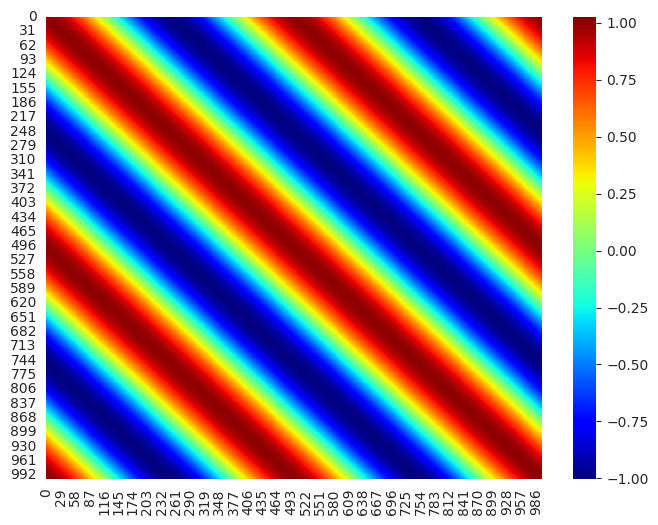

In [33]:
sns.set_style("white")
plt.figure(figsize=(8, 6))
sns.heatmap(g_pred, cmap='jet')
plt.show()

In [34]:
g_real = np.zeros((len(x_test), len(y_test)))
for i, xi in enumerate(x_test):
    for j, yj in enumerate(y_test):
        g_real[i, j] = np.cos(4*np.pi*(xi - yj))

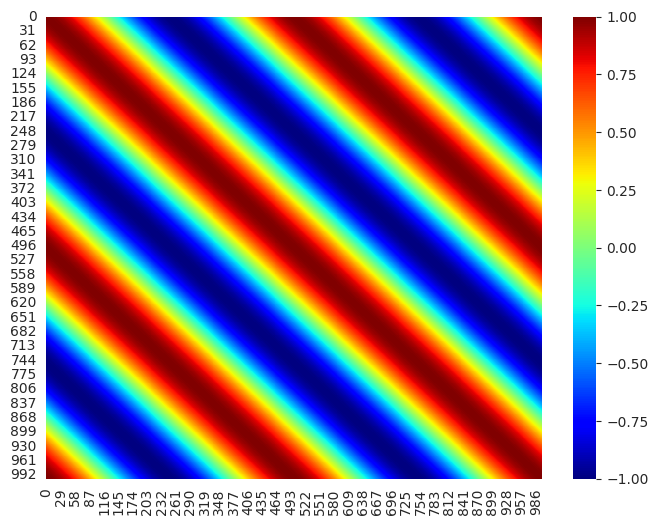

In [35]:
sns.set_style("white")
plt.figure(figsize=(8, 6))
sns.heatmap(g_real, cmap='jet')
plt.show()

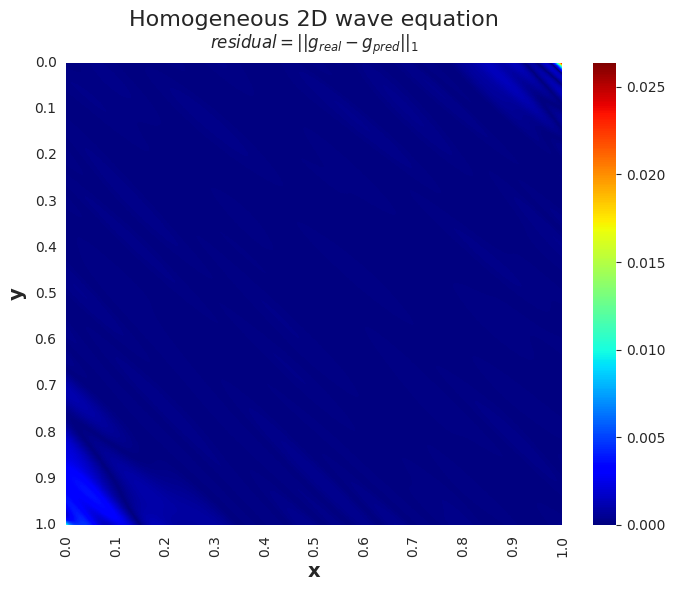

In [73]:
# sns.set_style("white")
plt.figure(figsize=(8, 6))
sns.heatmap(np.abs(g_real-g_pred), cmap='jet')
plt.xticks(np.arange(0.0, 1100.0, 100), ["{:.1f}".format(x) for x in np.arange(0.0, 1.1, 0.1)])
plt.yticks(np.arange(0.0, 1100.0, 100), ["{:.1f}".format(y) for y in np.arange(0.0, 1.1, 0.1)])
plt.xlabel(r'$\mathbf{x}$', fontsize=14)
plt.ylabel(r'$\mathbf{y}$', fontsize=14)

plt.text(0.5, 1.08, 'Homogeneous 2D wave equation', fontsize=16, ha='center', transform=plt.gca().transAxes)
# plt.text(0.5, 1.03, r'$\mathrm{ residual = ||g_{real} - g_{pred}|| }$', fontsize=12, ha='center', transform=plt.gca().transAxes)
plt.text(0.5, 1.03, r'$ residual = {||g_{real} - g_{pred}||}_1 $', fontsize=12, ha='center', transform=plt.gca().transAxes)

plt.show()

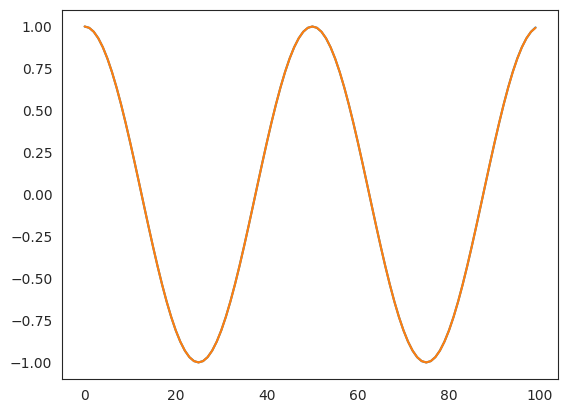

In [ ]:
plt.plot(g_pred[:, 0])
plt.plot(np.cos(4*np.pi*x_test))